In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from xgboost import XGBRegressor
from pathlib import Path

In [7]:
# --- CONFIGURATION ---
BASE_DIR = Path("./PS2-SIH25").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/xgb_models")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

SITE_IDS = [f"site_{i}" for i in range(1, 8)]
TARGETS = ["O3_target", "NO2_target"]

print(f"[INIT] Configuration loaded.")
print(f"  - Data Directory: {DATA_DIR}")
print(f"  - Model Artifacts will be saved to: {ARTIFACT_DIR}")

[INIT] Configuration loaded.
  - Data Directory: /content/PS2-SIH25/Data_SIH_2025 2
  - Model Artifacts will be saved to: artifacts/xgb_models


In [8]:

# --- 1. DATA PIPELINE ---
def load_and_process_data(site_id):
    """
    Loads raw data, interpolates missing values, and engineers Lag features.
    """
    file_path = DATA_DIR / f"{site_id}_train_data.csv"
    print(f"\n[DATA] Loading {site_id} from {file_path.name}...")

    df = pd.read_csv(file_path)
    initial_shape = df.shape

    # DateTime Conversion
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Missing Value Imputation (Linear Interpolation for Time Series)
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both').ffill().bfill()

    # Feature Engineering: Cyclical Time
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # Feature Engineering: Lags (The "Secret Sauce" for XGBoost)
    # We use past pollution levels to predict future levels
    lags = [1, 2, 3, 6, 12, 24]
    for t in TARGETS:
        for lag in lags:
            df[f"{t}_lag_{lag}"] = df[t].shift(lag)

    # Drop NaNs created by lagging
    df = df.dropna().reset_index(drop=True)

    print(f"  - Original Shape: {initial_shape}")
    print(f"  - Processed Shape: {df.shape} (Rows, Cols)")
    return df

In [29]:
def inspect_raw_data(site_id):
    """
    Loads raw data for a specific site and prints basic statistics.
    """
    file_path = DATA_DIR / f"{site_id}_train_data.csv"
    if not file_path.exists():
        print(f"[ERROR] File not found: {file_path}")
        return None

    df = pd.read_csv(file_path)

    print(f"\n--- INSPECTION: {site_id} ---")
    print(f"Shape: {df.shape} (Rows, Columns)")
    print("\n[HEAD] First 5 Rows:")
    display(df.head())

    print("\n[INFO] Data Types and Null Counts:")
    print(df.info())

    print("\n[DESCRIBE] Statistical Summary (Numerical Cols):")
    display(df.describe().T)

    return df

In [28]:
def plot_target_distribution(df, site_id):
    """
    Plots histograms for O3 and NO2 targets to check for skew/outliers.
    """
    plt.figure(figsize=(12, 5))

    for i, target in enumerate(TARGETS):
        plt.subplot(1, 2, i+1)
        sns.histplot(df[target], kde=True, color='skyblue' if i==0 else 'salmon')
        plt.title(f"{target} Distribution - {site_id}")
        plt.xlabel("Concentration")

    plt.tight_layout()
    plt.show()


--- INSPECTION: site_1 ---
Shape: (25081, 16) (Rows, Columns)

[HEAD] First 5 Rows:


,year,month,day,hour,O3_forecast,NO2_forecast,T_forecast,q_forecast,u_forecast,v_forecast,w_forecast,NO2_satellite,HCHO_satellite,ratio_satellite,O3_target,NO2_target
0,2022.0,7.0,28.0,0.0,73.35,57.54,22.99,7.68,-3.46,1.28,1.02,NaN,NaN,NaN,5.03,6.75
1,2022.0,7.0,28.0,1.0,82.77,57.25,23.90,7.70,-1.35,0.29,0.99,NaN,NaN,NaN,5.08,6.07
2,2022.0,7.0,28.0,2.0,92.19,56.97,23.89,7.72,0.76,-0.70,0.96,NaN,NaN,NaN,6.95,3.38
3,2022.0,7.0,28.0,3.0,101.62,56.68,23.92,7.74,2.87,-1.69,0.93,NaN,NaN,NaN,5.80,4.85
4,2022.0,7.0,28.0,4.0,113.51,64.06,25.55,7.81,2.45,-1.15,0.66,NaN,NaN,NaN,7.22,7.72



[INFO] Data Types and Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25081 entries, 0 to 25080
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             25081 non-null  float64
 1   month            25081 non-null  float64
 2   day              25081 non-null  float64
 3   hour             25081 non-null  float64
 4   O3_forecast      25081 non-null  float64
 5   NO2_forecast     25081 non-null  float64
 6   T_forecast       25081 non-null  float64
 7   q_forecast       25081 non-null  float64
 8   u_forecast       25081 non-null  float64
 9   v_forecast       25081 non-null  float64
 10  w_forecast       25081 non-null  float64
 11  NO2_satellite    827 non-null    float64
 12  HCHO_satellite   901 non-null    float64
 13  ratio_satellite  794 non-null    float64
 14  O3_target        25081 non-null  float64
 15  NO2_target       25081 non-null  float64
dtypes: float64(16)
memory 

,count,mean,std,min,25%,50%,75%,max
year,25081.0,2021.591484,1.451864,2019.00,2020.00,2022.00,2023.00,2024.00
month,25081.0,6.336829,3.442965,1.00,3.00,6.00,9.00,12.00
day,25081.0,15.708704,8.826802,1.00,8.00,16.00,23.00,31.00
hour,25081.0,11.499541,6.922567,0.00,5.00,11.00,17.00,23.00
O3_forecast,25081.0,69.472983,61.373626,0.00,23.02,46.70,111.76,524.31
NO2_forecast,25081.0,61.465255,41.902674,3.32,27.34,54.43,85.56,424.83
T_forecast,25081.0,23.903960,8.212070,2.85,17.61,25.60,29.88,44.85
q_forecast,25081.0,12.175782,5.455621,2.71,7.60,10.15,17.51,24.09
u_forecast,25081.0,0.377179,2.118990,-8.52,-1.17,0.67,1.89,8.17
v_forecast,25081.0,-0.484007,1.307774,-6.69,-1.46,-0.61,0.48,5.26


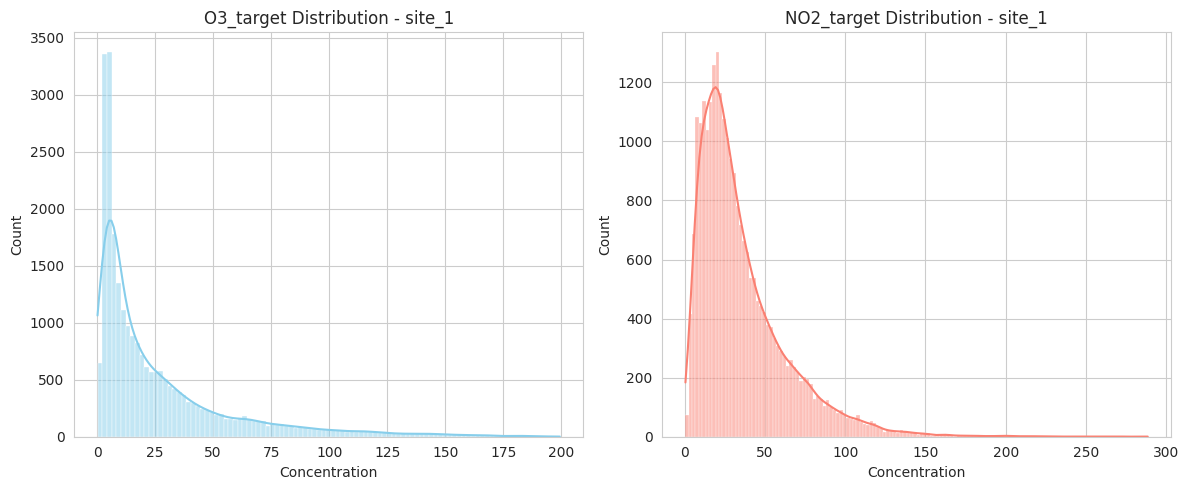

In [31]:
# 2. Deep Dive into Site 1
focus_site = "site_1"
df_site1 = inspect_raw_data(focus_site)


plot_target_distribution(df_site1, focus_site)

In [ ]:
def analyze_correlations(df, site_id):
    """
    Plots a correlation heatmap. Generates temporary lags for the plot.
    """
    temp_df = df.copy()

    # Interpolate to fix NaNs before correlation
    numeric_cols = temp_df.select_dtypes(include=["float", "int"]).columns.tolist()
    temp_df[numeric_cols] = temp_df[numeric_cols].interpolate(method='linear', limit_direction='both').ffill().bfill()

    # Create temporary lags
    lags = [1, 24]
    for t in TARGETS:
        for lag in lags:
            temp_df[f"{t}_lag_{lag}"] = temp_df[t].shift(lag)

    # Select interesting columns
    cols = ["O3_target", "O3_lag_1", "O3_lag_24", "NO2_target", "NO2_lag_1", "T_forecast", "u_forecast"]
    cols = [c for c in cols if c in temp_df.columns]

    plt.figure(figsize=(10, 8))
    sns.heatmap(temp_df[cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Feature Correlation Matrix - {site_id}")
    plt.show()

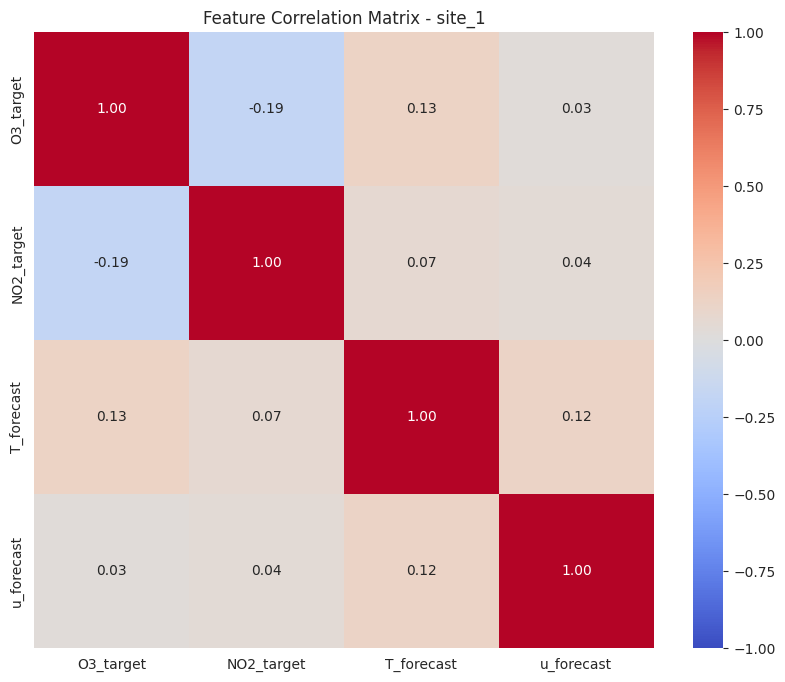

In [26]:
analyze_correlations(df_site1, focus_site)

In [21]:
def check_split_sizes(df):
    """
    Visualizes how the Chronological Split divides the data.
    """
    # --- FIX: Create timestamp if it doesn't exist yet ---
    if 'timestamp' not in df.columns:
        df = df.copy() # Work on a copy to be safe
        df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')

    # Sort just in case
    df = df.sort_values('timestamp').reset_index(drop=True)

    split_idx = int(len(df) * 0.85)
    train_df = df.iloc[:split_idx]
    val_df = df.iloc[split_idx:]

    print(f"\n[SPLIT VALIDATION]")
    print(f"Total Samples: {len(df)}")
    print(f"Training Set:  {len(train_df)} ({len(train_df)/len(df):.1%})")
    print(f"Validation Set: {len(val_df)} ({len(val_df)/len(df):.1%})")

    print(f"Train Range: {train_df['timestamp'].min()} -> {train_df['timestamp'].max()}")
    print(f"Val Range:   {val_df['timestamp'].min()} -> {val_df['timestamp'].max()}")

In [27]:
check_split_sizes(df_site1)


[SPLIT VALIDATION]
Total Samples: 25081
Training Set:  21318 (85.0%)
Validation Set: 3763 (15.0%)
Train Range: 2019-07-14 00:00:00 -> 2023-10-12 05:00:00
Val Range:   2023-10-12 06:00:00 -> 2024-06-30 00:00:00


In [9]:
# --- 2. TRAINING LOOP ---
def train_models():
    print("\n" + "="*40)
    print("STARTING TRAINING PIPELINE")
    print("="*40)

    for site in SITE_IDS:
        print(f"\n>>> PROCESSING {site.upper()}")

        # A. Prepare Data
        df = load_and_process_data(site)

        # B. Define Features (Exclude metadata & targets)
        drop_cols = ["timestamp", "year", "month", "day", "O3_target", "NO2_target"]
        features = [c for c in df.columns if c not in drop_cols]
        print(f"  - Features selected: {len(features)}")

        # C. Chronological Split (85% Train / 15% Holdout)
        # We split here just to validate during training (early stopping)
        split_idx = int(len(df) * 0.85)
        X = df[features]

        for target in TARGETS:
            y = df[target]

            X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

            print(f"  - Training Model for {target}...")
            print(f"    (Train Size: {len(X_train)}, Val Size: {len(X_val)})")

            # D. Train XGBoost
            model = XGBRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=6,
                n_jobs=-1,
                random_state=42,
                early_stopping_rounds=50
            )

            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            # E. Save Artifacts
            # We save a dictionary containing the model AND the feature list
            # This ensures the Evaluation notebook knows exactly which columns to use
            artifact = {
                "model": model,
                "features": features,
                "site": site,
                "target": target,
                "best_score": model.best_score
            }

            save_path = ARTIFACT_DIR / f"{site}_{target}.pkl"
            with open(save_path, "wb") as f:
                pickle.dump(artifact, f)

            print(f"    [SUCCESS] Model saved to {save_path.name}")

            # Optional: Quick Feature Importance Check
            if site == "site_1" and target == "O3_target":
                print("    [DEBUG] Top 3 Features for Reference:")
                imps = pd.Series(model.feature_importances_, index=features).nlargest(3)
                print(imps.to_string())

In [10]:
if __name__ == "__main__":
    train_models()
    print("\n[DONE] All models trained and saved to artifacts/.")


STARTING TRAINING PIPELINE

>>> PROCESSING SITE_1

[DATA] Loading site_1 from site_1_train_data.csv...
  - Original Shape: (25081, 16)
  - Processed Shape: (25057, 31) (Rows, Cols)
  - Features selected: 25
  - Training Model for O3_target...
    (Train Size: 21298, Val Size: 3759)
    [SUCCESS] Model saved to site_1_O3_target.pkl
    [DEBUG] Top 3 Features for Reference:
O3_target_lag_1     0.681069
hour_sin            0.099317
O3_target_lag_24    0.039804
  - Training Model for NO2_target...
    (Train Size: 21298, Val Size: 3759)
    [SUCCESS] Model saved to site_1_NO2_target.pkl

>>> PROCESSING SITE_2

[DATA] Loading site_2 from site_2_train_data.csv...
  - Original Shape: (25969, 16)
  - Processed Shape: (25945, 31) (Rows, Cols)
  - Features selected: 25
  - Training Model for O3_target...
    (Train Size: 22053, Val Size: 3892)
    [SUCCESS] Model saved to site_2_O3_target.pkl
  - Training Model for NO2_target...
    (Train Size: 22053, Val Size: 3892)
    [SUCCESS] Model saved 

#Evaluation

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

In [12]:
# --- CONFIGURATION ---
BASE_DIR = Path("./PS2-SIH25").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/xgb_models")

SITE_IDS = [f"site_{i}" for i in range(1, 8)]
TARGETS = ["O3_target", "NO2_target"]


In [13]:
# --- 1. DATA LOADING (Must match Training Logic) ---
def get_validation_data(site_id):
    """
    Re-loads data and returns ONLY the validation portion (last 15%).
    Crucially, it regenerates the exact same features (Lags).
    """
    df = pd.read_csv(DATA_DIR / f"{site_id}_train_data.csv")

    # Preprocessing must differ slightly? No, must be identical to training.
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    df = df.sort_values("timestamp").reset_index(drop=True)

    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both').ffill().bfill()

    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    lags = [1, 2, 3, 6, 12, 24]
    for t in TARGETS:
        for lag in lags:
            df[f"{t}_lag_{lag}"] = df[t].shift(lag)

    df = df.dropna().reset_index(drop=True)

    # Split Logic
    split_idx = int(len(df) * 0.85)
    val_df = df.iloc[split_idx:].copy()

    return val_df

In [14]:
# --- 2. EVALUATION ENGINE ---
def evaluate_models():
    print("="*60)
    print("STEP 1: LOADING MODELS & RUNNING INFERENCE")
    print("="*60)

    results = []

    for site in SITE_IDS:
        # Load Validation Data for this site
        val_df = get_validation_data(site)
        timestamps = val_df["timestamp"]

        for target in TARGETS:
            # Load the specific model
            model_path = ARTIFACT_DIR / f"{site}_{target}.pkl"
            if not model_path.exists():
                print(f"[WARN] Model for {site} {target} not found. Skipping.")
                continue

            with open(model_path, "rb") as f:
                artifact = pickle.load(f)

            model = artifact["model"]
            features = artifact["features"] # Use the exact feature list from training

            # Prepare Inputs
            X_val = val_df[features]
            y_true = val_df[target]

            # Predict
            preds = model.predict(X_val)

            # Calculate Metrics
            mae = mean_absolute_error(y_true, preds)
            rmse = np.sqrt(mean_squared_error(y_true, preds))
            r2 = r2_score(y_true, preds)

            results.append({
                "Site": site,
                "Target": target,
                "MAE": mae,
                "RMSE": rmse,
                "R2": r2,
                "N_Samples": len(val_df)
            })

            # --- PLOTTING (Zoomed to last week for clarity) ---
            plot_inference(site, target, timestamps, y_true, preds, mae, r2)

    # --- SUMMARY TABLE ---
    print("\n" + "="*60)
    print("STEP 2: FINAL PERFORMANCE REPORT")
    print("="*60)
    results_df = pd.DataFrame(results)
    print(results_df.round(4).to_string(index=False))

    print("\n[AVERAGES]")
    print(results_df.groupby("Target")[["MAE", "R2"]].mean())

STEP 1: LOADING MODELS & RUNNING INFERENCE


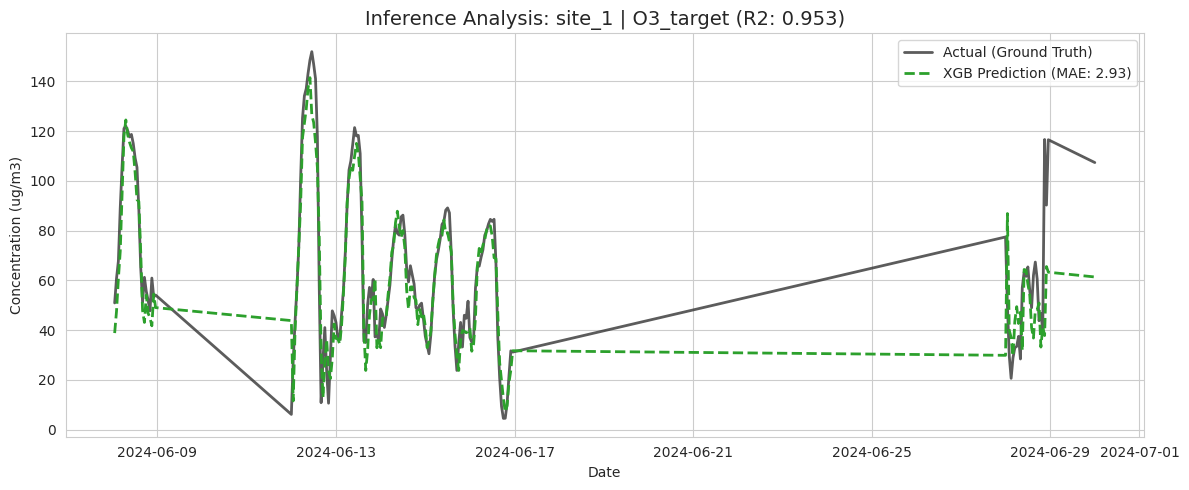

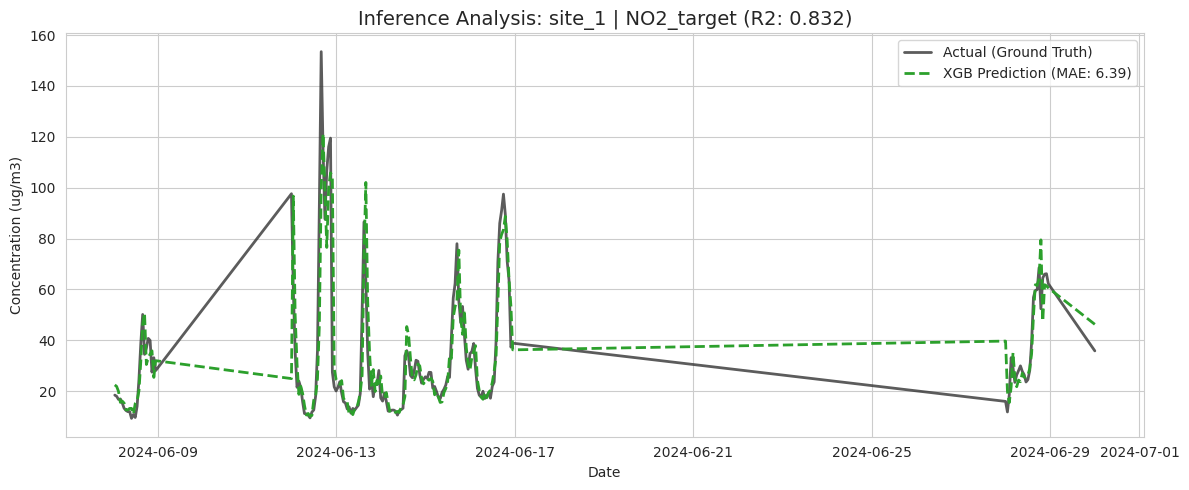

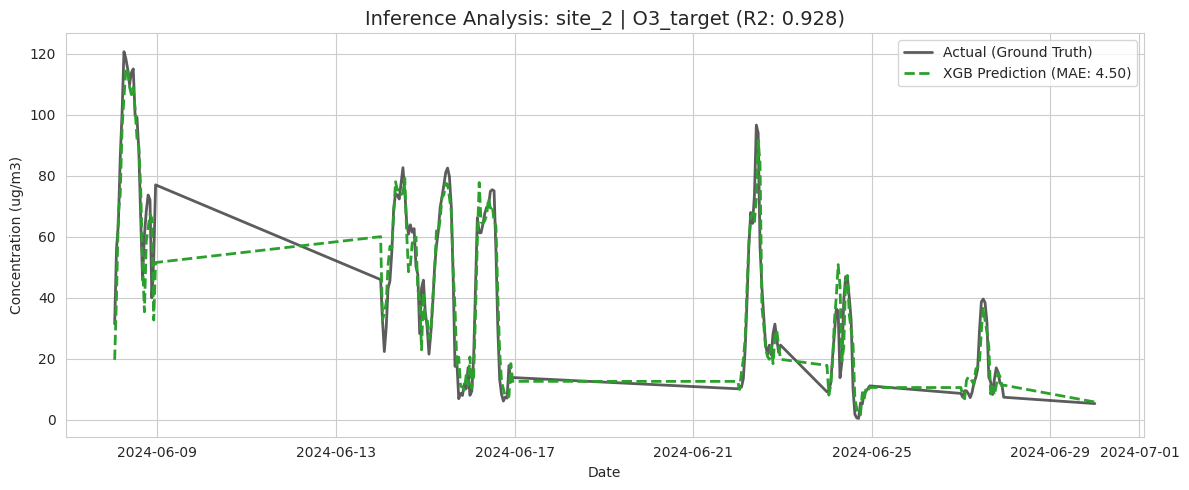

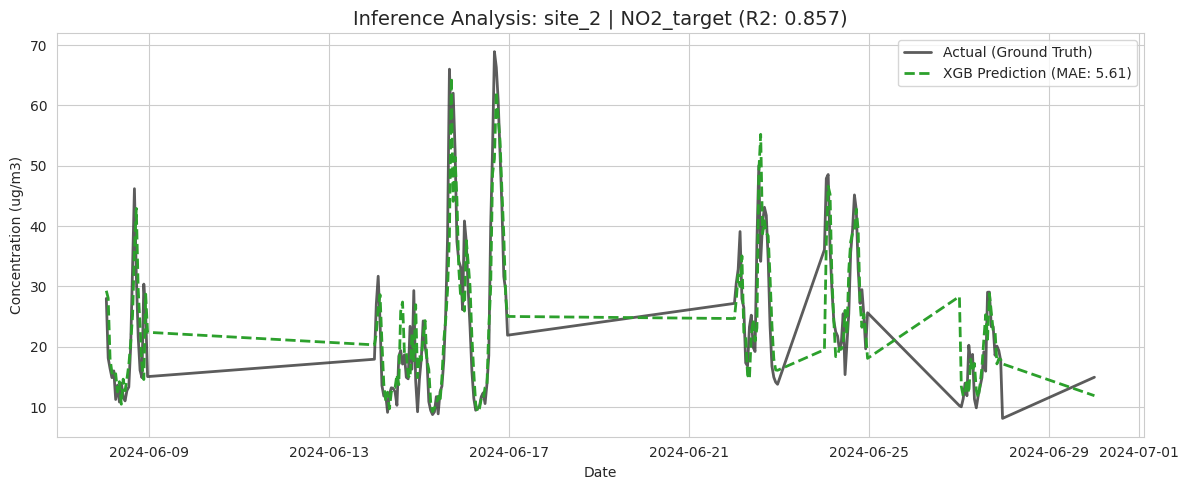

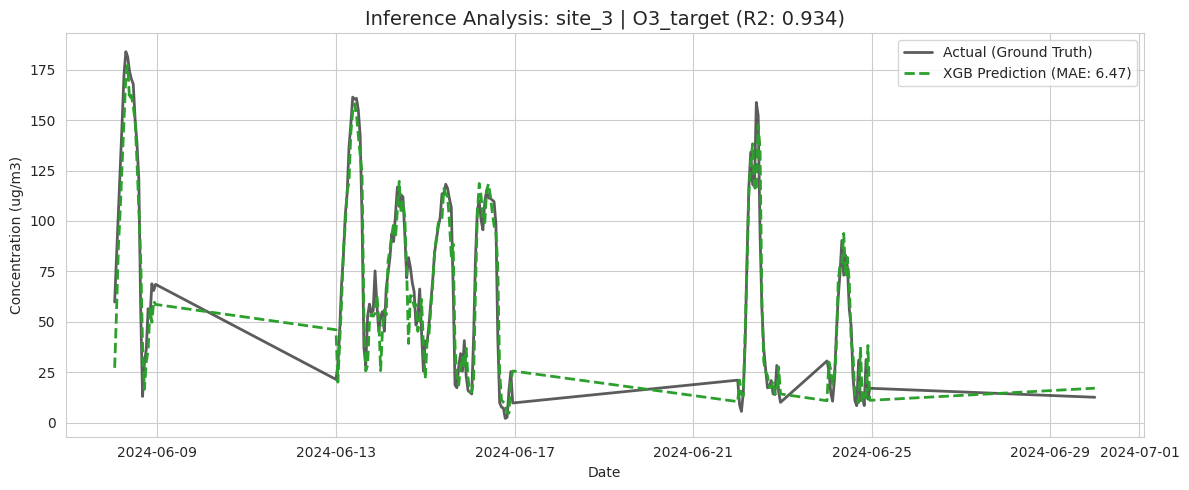

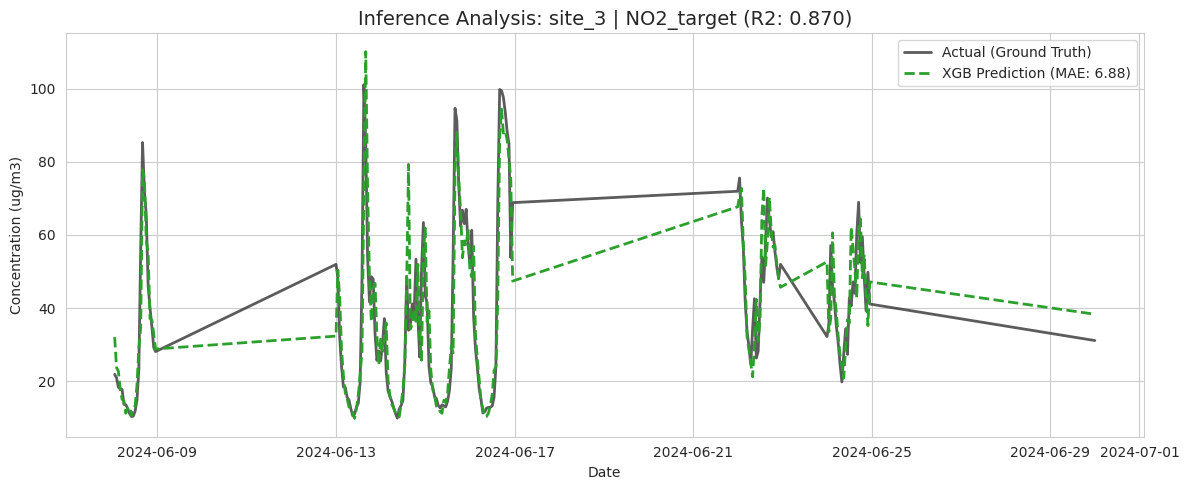

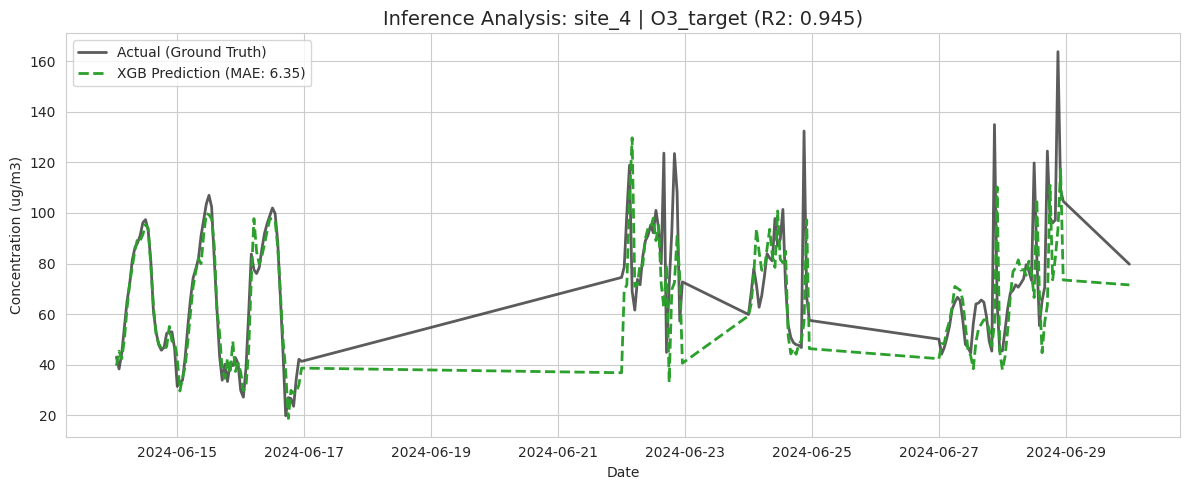

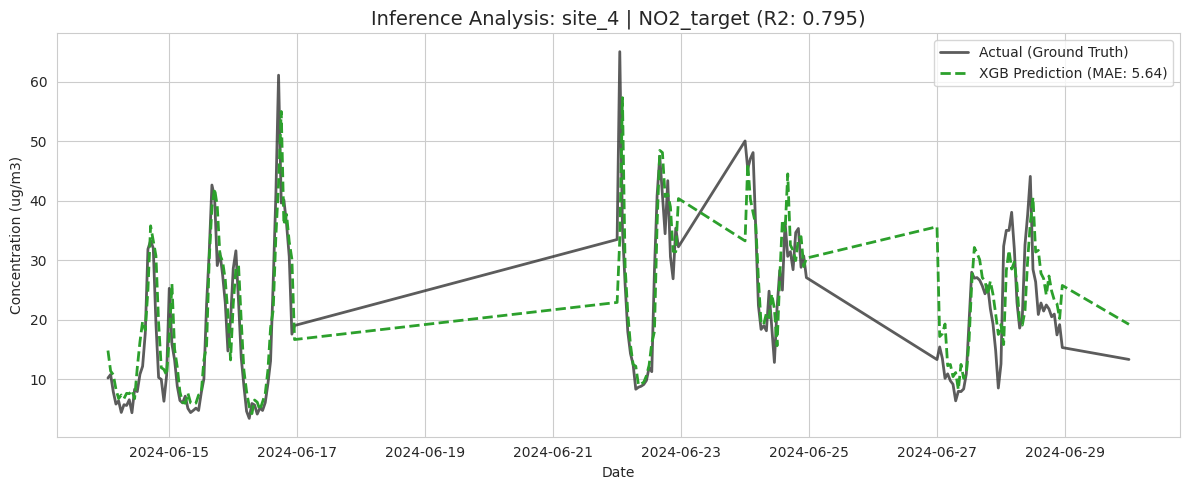

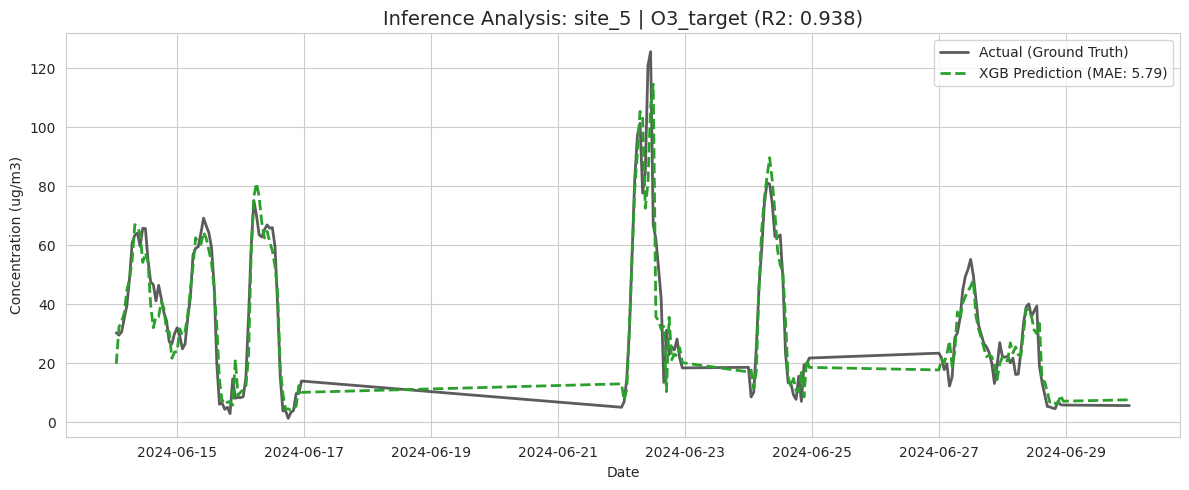

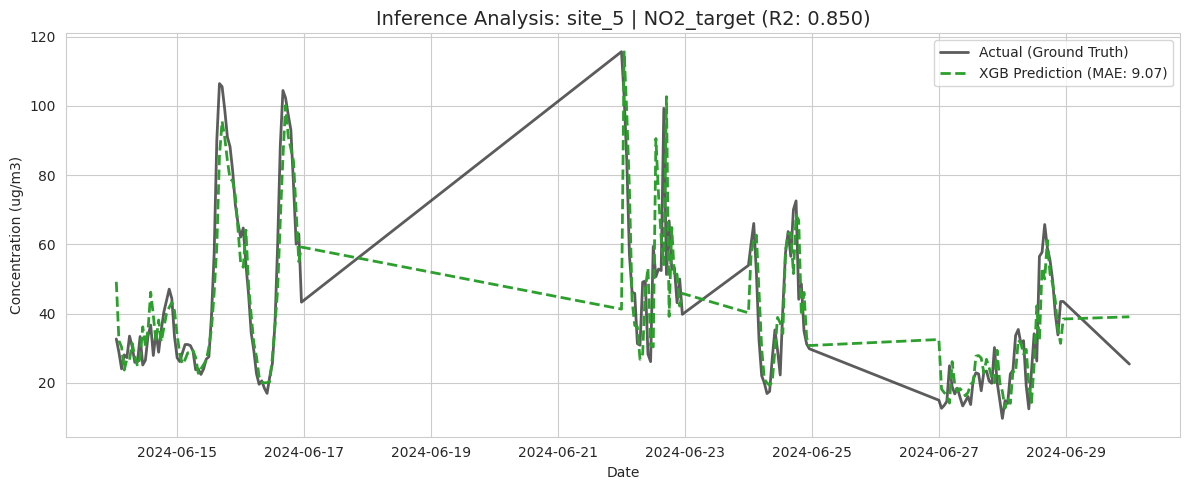

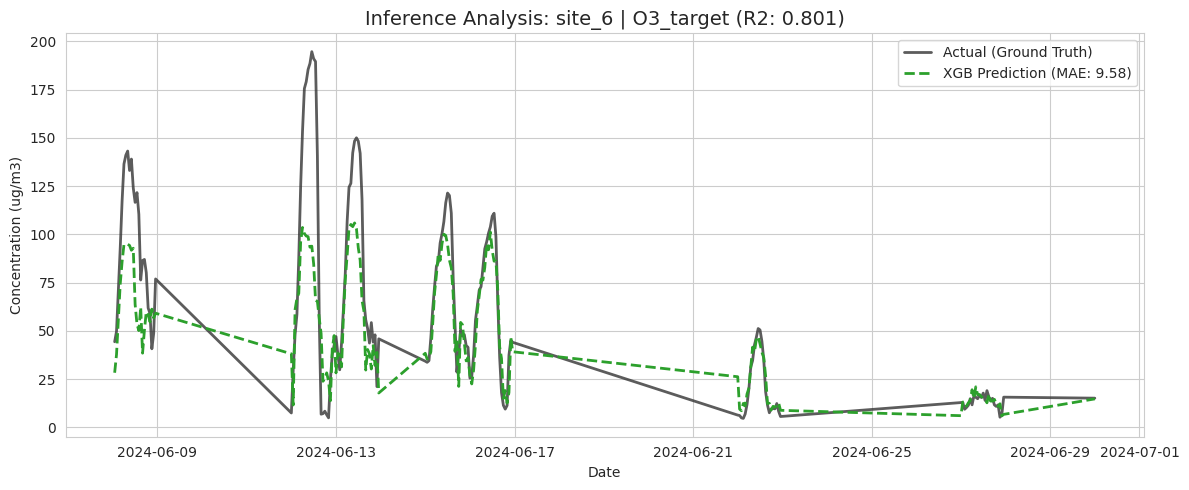

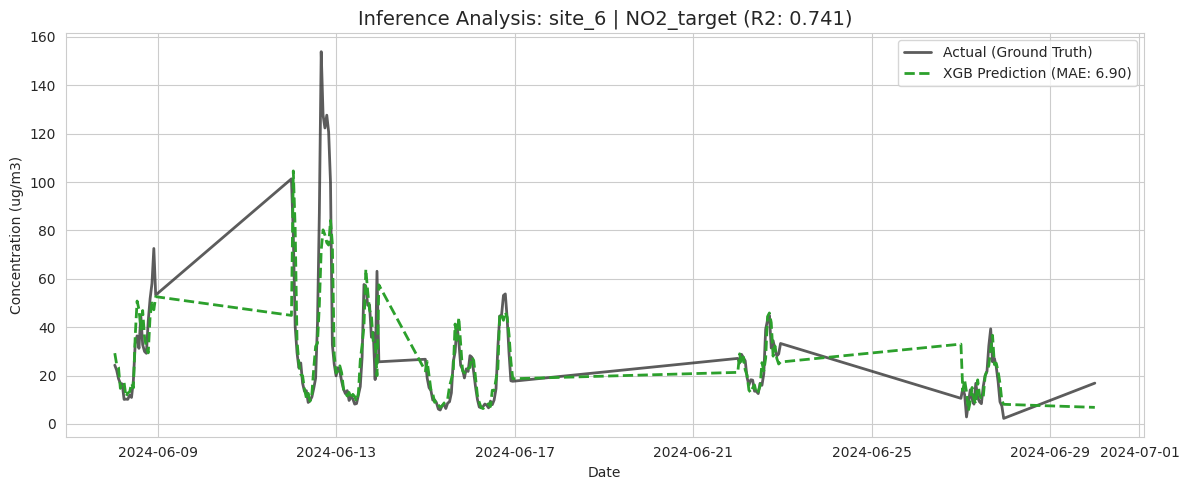

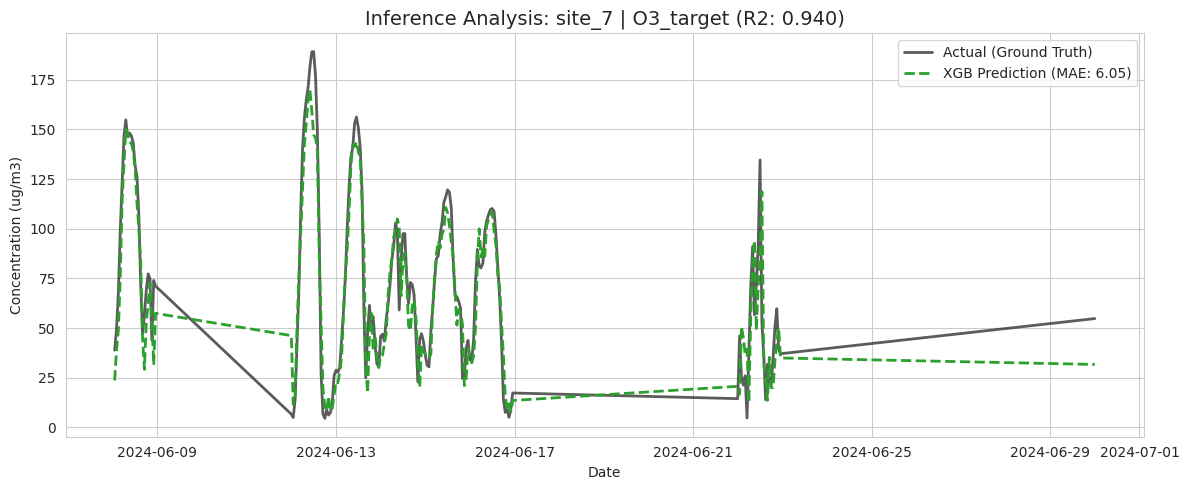

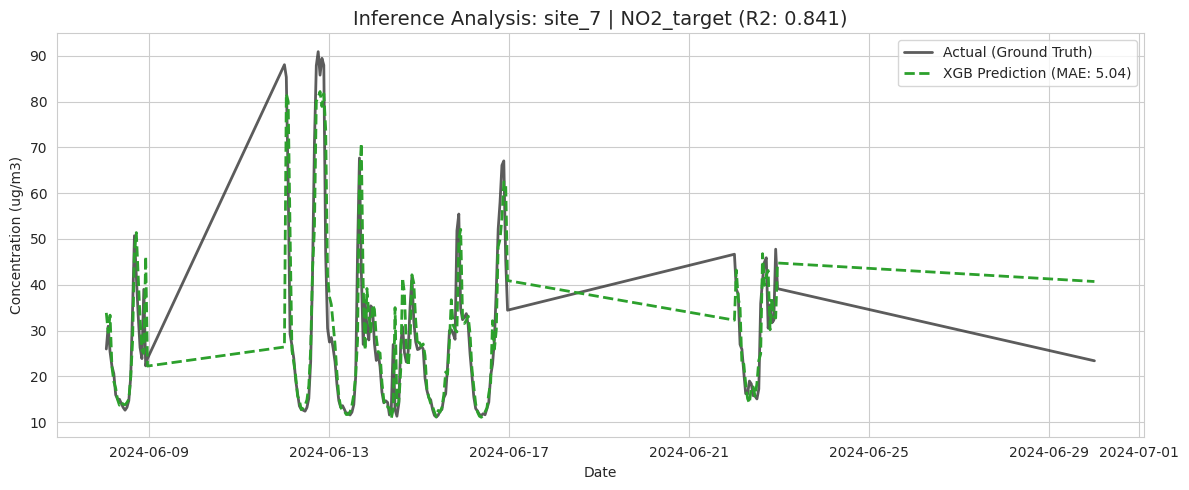


STEP 2: FINAL PERFORMANCE REPORT
  Site     Target    MAE    RMSE     R2  N_Samples
site_1  O3_target 2.9299  6.7183 0.9530       3759
site_1 NO2_target 6.3946 11.0333 0.8320       3759
site_2  O3_target 4.5016  7.8319 0.9278       3892
site_2 NO2_target 5.6109  8.6875 0.8573       3892
site_3  O3_target 6.4671 10.7964 0.9340       3284
site_3 NO2_target 6.8809 10.7787 0.8698       3284
site_4  O3_target 6.3451  9.9309 0.9445       3673
site_4 NO2_target 5.6382  8.5945 0.7953       3673
site_5  O3_target 5.7881  9.0846 0.9381       3759
site_5 NO2_target 9.0681 15.2080 0.8504       3759
site_6  O3_target 9.5755 17.9438 0.8008       3950
site_6 NO2_target 6.8957 11.6006 0.7410       3950
site_7  O3_target 6.0487  9.4596 0.9404       3413
site_7 NO2_target 5.0376  8.2269 0.8408       3413

[AVERAGES]
                 MAE        R2
Target                        
NO2_target  6.503702  0.826655
O3_target   5.950872  0.919797


In [15]:
def plot_inference(site, target, timestamps, y_true, y_pred, mae, r2):
    # Visualization settings
    zoom = 168 # Last 1 week (24 * 7)

    plt.figure(figsize=(12, 5))
    sns.set_style("whitegrid")

    # Plot Actuals
    plt.plot(timestamps.values[-zoom:], y_true.values[-zoom:],
             label="Actual (Ground Truth)", color='#333333', linewidth=2, alpha=0.8)

    # Plot Predictions
    plt.plot(timestamps.values[-zoom:], y_pred[-zoom:],
             label=f"XGB Prediction (MAE: {mae:.2f})", color='#2ca02c', linewidth=2, linestyle='--')

    plt.title(f"Inference Analysis: {site} | {target} (R2: {r2:.3f})", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Concentration (ug/m3)")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_models()